## 准备工作

1.确保您按照[README](README-CN.md)中的说明在环境中设置了API密钥

2.安装依赖包

In [1]:
%pip install openai pandas matplotlib plotly scikit-learn numpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 1. 生成 Embedding (基于 text-embedding-ada-002 模型)

嵌入对于处理自然语言和代码非常有用，因为其他机器学习模型和算法（如聚类或搜索）可以轻松地使用和比较它们。

![Embedding](images/embedding-vectors.svg)

### 大众点评评论数据集(/data/dianping_comment_data.csv)

Source:[大众点评评论数据集](https://www.heywhale.com/mw/dataset/5ecdf41c12fba90036cf11fc)

In [3]:
'''
Author: leyi leyi@myun.info
Date: 2023-07-25 11:45:21
LastEditors: leyi leyi@myun.info
LastEditTime: 2023-09-09 20:06:24
FilePath: /learning-openai/openai_api/embedding.ipynb
Description: 

Copyright (c) 2023 by ${git_name_email}, All Rights Reserved. 
'''
# 导入 pandas 包。Pandas 是一个用于数据处理和分析的 Python 库
# 提供了 DataFrame 数据结构，方便进行数据的读取、处理、分析等操作。
import pandas as pd
# 导入 tiktoken 库。Tiktoken 是 OpenAI 开发的一个库，用于从模型生成的文本中计算 token 数量。
import tiktoken
import openai
# 从 openai.embeddings_utils 包中导入 get_embedding 函数。
# 这个函数可以获取 GPT-3 模型生成的嵌入向量。
# 嵌入向量是模型内部用于表示输入数据的一种形式。
from openai.embeddings_utils import get_embedding

openai.api_key='sk-xxx'

#### 加载数据集

In [7]:
input_datapath = "data/dianping_comment_data.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df[["comment_time", "shopID", "cus_id", "stars", "kouwei","huanjing","fuwu","cus_comment"]]
df = df.dropna()

# 将 "kouwei" 、"huanjing"、"fuwu"(口味、环境、服务) 和 "cus_comment" 字段组合成新的字段 "combined"
df["combined"] = (
    "口味: " + df.kouwei.str.strip() + "; huanjing: " + df.huanjing.str.strip() + "; fuwu: " + df.fuwu.str.strip() + "; 顾客评价: " + df.cus_comment.str.strip()
)
df.head(2)

,comment_time,shopID,cus_id,stars,kouwei,huanjing,fuwu,cus_comment,combined
id,,,,,,,,,
0,2018/9/20 6:48,518986,迷糊泰迪,4,非常好,好,好,南信 算是 广州 著名 甜品店 吧 好几个 时间段 路过 都 是 座无虚席 看着 餐单 上 ...,口味: 非常好; huanjing: 好; fuwu: 好; 顾客评价: 南信 算是 广州 ...
1,2018/9/22 21:49,518986,稱霸幼稚園,4,很好,很好,很好,中午 吃 完 了 所谓 的 早茶 回去 放下 行李 休息 了 会 就 来 吃 下午茶 了 服...,口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 中午 吃 完 了...


In [8]:
df["combined"]

id
0      口味: 非常好; huanjing: 好; fuwu: 好; 顾客评价: 南信 算是 广州 ...
1      口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 中午 吃 完 了...
2      口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 冲刺 王者 战队...
3      口味: 非常好; huanjing: 很好; fuwu: 很好; 顾客评价: 都 说来 广州...
4      口味: 非常好; huanjing: 很好; fuwu: 很好; 顾客评价: 一直 很 期待...
                             ...                        
995    口味: 很好; huanjing: 非常好; fuwu: 非常好; 顾客评价: 点 的 红豆...
996    口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 不 记得 多少 ...
997    口味: 很好; huanjing: 好; fuwu: 好; 顾客评价: 在 上下 九 步行街...
998    口味: 非常好; huanjing: 非常好; fuwu: 非常好; 顾客评价: 人 真的 ...
999    口味: 好; huanjing: 一般; fuwu: 一般; 顾客评价: 一碗 姜撞奶 等 ...
Name: combined, Length: 1000, dtype: object

#### Embedding 模型关键参数

In [9]:
# 模型类型
# 建议使用官方推荐的第二代嵌入模型：text-embedding-ada-002
embedding_model = "text-embedding-ada-002"
# text-embedding-ada-002 模型对应的分词器（TOKENIZER）
embedding_encoding = "cl100k_base"
# text-embedding-ada-002 模型支持的输入最大 Token 数是8191，向量维度 1536
# 在我们的 DEMO 中过滤 Token 超过 8000 的文本
max_tokens = 8000  

#### 将样本减少到最近的1,000个评论，并删除过长的样本


In [10]:
top_n = 1000
# 首先将前2k个条目进行初始筛选，假设不到一半会被过滤掉。
df = df.sort_values("comment_time").tail(top_n * 2) 
df.drop("comment_time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# 忽略太长无法嵌入的评论
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
# 删除Token超长的样本
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

#### 生成 Embeddings 并保存（非必须步骤，可直接复用项目中文件）

In [11]:
# 实际生成会耗时几分钟
# 提醒：非必须步骤，可直接复用项目中的嵌入文件 fine_food_reviews_with_embeddings_1k
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

output_datapath = "data/dianping_comment_with_embeddings.csv"

df.to_csv(output_datapath)

## 2.读取 dianping_comment_with_embeddings 嵌入文件

In [12]:
embedding_datapath = "data/dianping_comment_with_embeddings.csv"

df_embeded = pd.read_csv(embedding_datapath, index_col=0)

#### 查看 Embedding 结果

In [13]:
df_embeded["embedding"]

id
999    [-0.01844363659620285, -0.005719561595469713, ...
998    [-0.007286964450031519, 0.015987718477845192, ...
997    [-0.005452522076666355, -0.0015960809541866183...
996    [0.008548376150429249, -0.0019543496891856194,...
995    [-0.007945582270622253, 0.0049283551052212715,...
                             ...                        
107    [0.0011700467439368367, 0.004703405313193798, ...
106    [-0.0006333747878670692, 0.001575793488882482,...
105    [-0.006310772150754929, 0.0039421794936060905,...
104    [0.0026372403372079134, 0.01412329263985157, 0...
103    [0.0015103882178664207, 0.0019279074622318149,...
Name: embedding, Length: 1000, dtype: object

In [14]:
len(df_embeded["embedding"][0])

34399

In [15]:
type(df_embeded["embedding"][0])

str

In [16]:
import ast

# 将字符串转换为向量
df_embeded["embedding_vec"] = df_embeded["embedding"].apply(ast.literal_eval)

In [17]:
len(df_embeded["embedding_vec"][0])

1536

## 3. 使用 t-SNE 可视化 1536 维 Embedding 美食评论

In [18]:
# 导入 NumPy 包，NumPy 是 Python 的一个开源数值计算扩展。这种工具可用来存储和处理大型矩阵，
# 比 Python 自身的嵌套列表（nested list structure)结构要高效的多。
import numpy as np
# 从 matplotlib 包中导入 pyplot 子库，并将其别名设置为 plt。
# matplotlib 是一个 Python 的 2D 绘图库，pyplot 是其子库，提供了一种类似 MATLAB 的绘图框架。
import matplotlib.pyplot as plt
import matplotlib

# 从 sklearn.manifold 模块中导入 TSNE 类。
# TSNE (t-Distributed Stochastic Neighbor Embedding) 是一种用于数据可视化的降维方法，尤其擅长处理高维数据的可视化。
# 它可以将高维度的数据映射到 2D 或 3D 的空间中，以便我们可以直观地观察和理解数据的结构。
from sklearn.manifold import TSNE

In [19]:
type(df_embeded["embedding_vec"])

pandas.core.series.Series

In [20]:
# 首先，确保你的嵌入向量都是等长的
assert df_embeded['embedding_vec'].apply(len).nunique() == 1

In [21]:
# 将嵌入向量列表转换为二维 numpy 数组
matrix = np.vstack(df_embeded['embedding_vec'].values)

In [23]:
# 创建一个 t-SNE 模型，t-SNE 是一种非线性降维方法，常用于高维数据的可视化。
# n_components 表示降维后的维度（在这里是2D）
# perplexity 可以被理解为近邻的数量
# random_state 是随机数生成器的种子
# init 设置初始化方式
# learning_rate 是学习率。
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [24]:
# 使用 t-SNE 对数据进行降维，得到每个数据点在新的2D空间中的坐标
vis_dims = tsne.fit_transform(matrix)

In [25]:
# 定义了五种不同的颜色，用于在可视化中表示不同的等级
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]

In [27]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embeded.stars.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embeded.stars.values)

Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

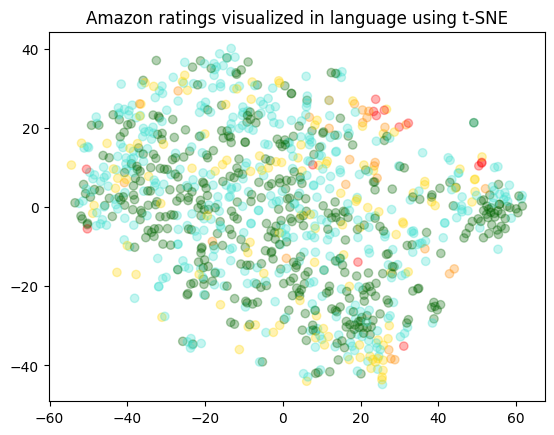

In [28]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

**t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。**

## 4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [29]:
import numpy as np
# 从 scikit-learn中导入 KMeans 类。KMeans 是一个实现 K-Means 聚类算法的类。
from sklearn.cluster import KMeans

# np.vstack 是一个将输入数据堆叠到一个数组的函数（在垂直方向）。
# 这里它用于将所有的 ada_embedding 值堆叠成一个矩阵。
# matrix = np.vstack(df.ada_embedding.values)

# 定义要生成的聚类数。
n_clusters = 4

# 创建一个 KMeans 对象，用于进行 K-Means 聚类。
# n_clusters 参数指定了要创建的聚类的数量；
# init 参数指定了初始化方法（在这种情况下是 'k-means++'）；
# random_state 参数为随机数生成器设定了种子值，用于生成初始聚类中心。
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)

# 使用 matrix（我们之前创建的矩阵）来训练 KMeans 模型。这将执行 K-Means 聚类算法。
kmeans.fit(matrix)

# kmeans.labels_ 属性包含每个输入数据点所属的聚类的索引。
# 这里，我们创建一个新的 'Cluster' 列，在这个列中，每个数据点都被赋予其所属的聚类的标签。
df_embeded['Cluster'] = kmeans.labels_

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
df_embeded['Cluster']

id
999    3
998    3
997    0
996    2
995    1
      ..
107    2
106    1
105    1
104    1
103    3
Name: Cluster, Length: 1000, dtype: int32

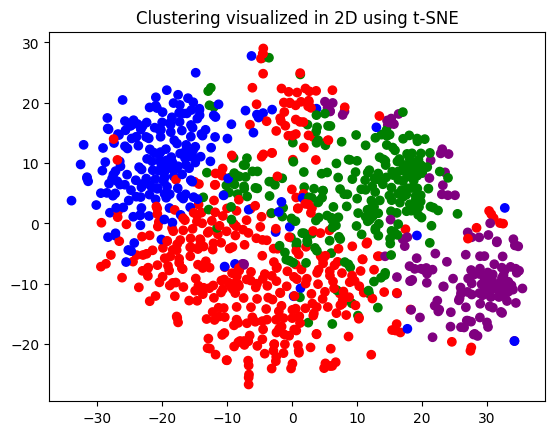

In [32]:
# 首先为每个聚类定义一个颜色。
colors = ["red", "green", "blue", "purple"]

# 然后，你可以使用 t-SNE 来降维数据。这里，我们只考虑 'embedding_vec' 列。
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)

# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embeded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

**K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。**

## 5. 使用 Embedding 进行文本搜索

![cosine](images/cosine.png)

In [33]:
# cosine_similarity 函数计算两个嵌入向量之间的余弦相似度。
from openai.embeddings_utils import get_embedding, cosine_similarity

In [34]:
type(df_embeded["embedding_vec"][0])

list

In [35]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [36]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embeded, '好吃的双皮奶', n=3)

口味: 好; huanjing: 好; fuwu: 好; 顾客评价: 探店 南信 牛奶 甜品 专家 之前 在 抖音 看过 说 是 广州 第一 好吃 的 双皮奶 下班 特地来 拔草 一下 双皮奶 本来 想 在 这里 解决 晚饭 但是 这里 的 正餐 都 挺 贵 的 看 别的 桌 的 挺 大 一份 我 一个 人 吃 就 不点 了 点 了 一份 双皮奶 其实 感觉 还好 吧 也 没有 特别 印象 深刻 

口味: 非常好; huanjing: 非常好; fuwu: 非常好; 顾客评价: 看到 很多 人 都 推荐 南信 甜品 里 的 双皮奶 那天 正好 在 上下 九 就 跑 过去 打卡 凑热闹 啦 当时 起码 是 点 但是 一楼 还是 坐满 了 人 我们 去 楼 也 是 勉强 找到 了 两个 相邻 的 位置 坐在 一起 红豆 拌 椰汁 双皮奶 口感 真的 很 不错 作为 一枚 吃货 真的 觉得 这 是

口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 没想到 双皮奶 可以 这么 好吃 的 害 的 我 两天 去 了 三次 每次 都 只 吃 双皮奶 水 牛奶 制作 奶香 十足 点 的 冻 双皮奶 在 夏天 吃 真的 是 绝 了 韭菜 萝卜 味道 入 萝卜 里面 了 感觉 吃口 甜 的 在 吃 口 咸 的 爽歪歪 啊 价格便宜 东西 量 大 实惠 难怪 那么 多人来 吃



In [37]:
df_embeded['Cluster']

id
999    3
998    3
997    0
996    2
995    1
      ..
107    2
106    1
105    1
104    1
103    3
Name: Cluster, Length: 1000, dtype: int32

In [38]:
# 选一条类别3的评论
df_embeded['combined'][0]

'口味: 非常好; huanjing: 好; fuwu: 好; 顾客评价: 南信 算是 广州 著名 甜品店 吧 好几个 时间段 路过 都 是 座无虚席 看着 餐单 上 密密麻麻 满满当当 好吃 的 容易 范 选择 困难 症拼桌 的 体验 不是 最好 人多 嘈杂 只想 快点 吃 完 赶紧 撤 自己 到 收银台 点单 服务员 只管 上菜 食物 味道 还是 要点 赞 的'

In [39]:
res = search_reviews(df_embeded, df_embeded['combined'][0], n=3)

口味: 非常好; huanjing: 好; fuwu: 好; 顾客评价: 南信 算是 广州 著名 甜品店 吧 好几个 时间段 路过 都 是 座无虚席 看着 餐单 上 密密麻麻 满满当当 好吃 的 容易 范 选择 困难 症拼桌 的 体验 不是 最好 人多 嘈杂 只想 快点 吃 完 赶紧 撤 自己 到 收银台 点单 服务员 只管 上菜 食物 味道 还是 要点 赞 的

口味: 非常好; huanjing: 非常好; fuwu: 非常好; 顾客评价: 又 到 广州 了 上次 来 已 是 近十年 前 了 就 对 广州 的 小吃 尤其 是 甜品 印象 深刻 这回 又 专门 到 上下 九 步行街 来 吃 这家 南信 甜品 人超 多 人气 旺得 不要 不要 的 但 服务员 态度 很 好 积极 帮 你 找 座位 上 茶 催单 令人满意 他家 的 甜品 呢 可以 说 非常 棒

口味: 非常好; huanjing: 好; fuwu: 好; 顾客评价: 在 上下 九 隔壁 有 一家 混在 一起 的 也 看到 了 南信 差点 进去 吃 了 一定 要 认准 这家 只有 一家 别无分店 生意 很 好 里面 人 超级 多 一楼 现金 二楼 手机 菜单 墙上 有个 大 的 小 的 每个 桌子 下压 着 分 甜品 咸品 由于 都 吃饱 了 就 点 了 甜品 奶味 好 浓赞



In [40]:
res = search_reviews(df_embeded, '好吃的甜品', n=3)

口味: 好; huanjing: 好; fuwu: 好; 顾客评价: 来到 南信 就 进来 尝个 甜品 看 了 点评 点 了 推荐 的 杨枝 甘露 拌 雪糕 和 凤凰 奶糕 都 不错

口味: 好; huanjing: 好; fuwu: 好; 顾客评价: 大明 顶顶 的 甜品店 在 上下 九 步行街 特地去 拔草 的 炎炎夏日 走 到 那里 发现 上 下层 都 是 茫茫人海 要堂 吃 估计 至少 等 一 小时 然后 在 最 前面 拿 的 外卖 双皮奶 据说 很 好吃 无奈 都 不凉 了 吃 出 了 奶 腥味 不甜 倒 是 很 喜欢 实在 是 失望 外卖 也 要 好好 做 啊 莲子

口味: 很好; huanjing: 很好; fuwu: 很好; 顾客评价: 来 广州 旅游 必吃 的 甜品店 艇 仔粥 各式 双皮奶 姜撞奶 等等 都 很 好吃 招牌 牛 三星 可能 不 太合 我 口味 甜味 过重 酸 辣味 不够 吃 多 了 有点 腻 建议 两个 人 吃 一份 就够 了 临走前 还 掐着 时间 等 它 开门 又 吃 了 一次 哈哈 重度 甜品 爱好者



In [41]:
res = search_reviews(df_embeded, '不好吃', n=5)

口味: 差; huanjing: 好; fuwu: 好; 顾客评价: 太 难吃 了 去 旅游 在 酒店 点 了 外卖 没想到 这么 难吃

口味: 好; huanjing: 好; fuwu: 好; 顾客评价: 一般 没有 吃 了 让 你 还 想 再 吃 的 冲动

口味: 差; huanjing: 差; fuwu: 差; 顾客评价: 超级 恶心 打包 了 三份 回家 吃 到 第二份 的 时候 直接 吃 出 不 知道 是 什么 跟 锈 铁丝 一样 的 不明 物体 看到 多赞 才 敢 来 吃 的 排队 等 半天 结果 就 等到 这 玩意 没人 吃 了 拉肚子 的

口味: 非常好; huanjing: 很好; fuwu: 很好; 顾客评价: 就是 老字号 出品 赞 甜品 为什么 就 能 不 那么 涨 肚子 呢 真想 把 甜品 上面 的 一次 吃 完

口味: 好; huanjing: 好; fuwu: 好; 顾客评价: 姜撞 奶太甜 吃 一口 就 腻 了 凝固 的 不是 很 成形 不如 路边 无名 小店 杨枝 甘露 还 可以

